# Part 1: Small-scale QAOA

## Step 0: Initalize Graph

Max-Cut problem $\rightarrow$ classical combinatorial optimization problem
- $\min_{x \in \{0,1\}^n} f(x)$

- $\max_{x \in \{0,1\}^n} \sum_{(i,j)} x_i + x_j - 2x_i x_j$
- $\min_{x \in \{0,1\}^n} \sum_{(i,j)} 2x_i x_j - x_i - x_j$


$min f(x)$ in this case is when the number of edges traversed by the cut is maximal

Initialize the problem by creating a graph with $n = 5$ nodes

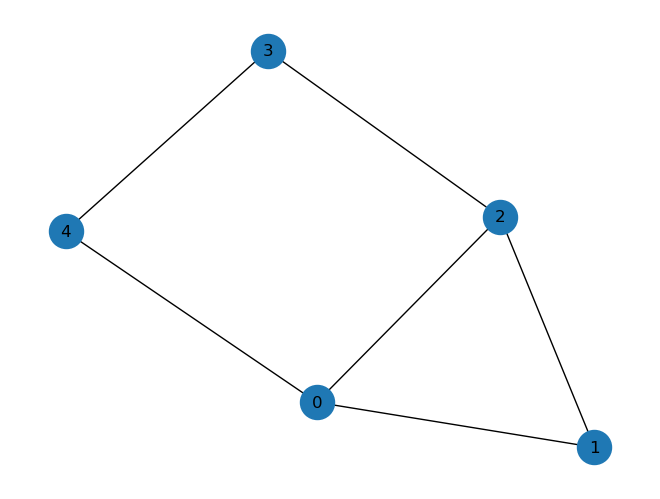

In [4]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph() # initalize rustworkx graph class
graph.add_nodes_from(np.arange(0, n, 1)) # add n nodes
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)] # this is a list of nodes and their weighted edges, edges here are bidirectional
graph.add_edges_from(edge_list) # add the edges to the graph
draw_graph(graph, node_size=600, with_labels=True) # display the graph

## Step 1: Map classical inputs to a quantum problem

Goals:

$\rightarrow$ Map the classical problem (graph) into quantum circuits and operators
- Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function
- Create a quantum circuit which will prepare the ground state of this Hamiltonian (using quantum annealing, aka a heuristic form of AQC)

QAOA: Quantum Approximate Optimization Algorithm Methodology
- Operator (Hamiltonian) for the cost function
- Ansatz (parameterized quantum circuit) that generates potential solutions, use the cost function to find the best one



Optimization problem (QAOA) $\rightarrow$ Hamiltonian

$H_C = \sum_{ij} Q_{ij} Z_i Z_j + \sum_{i} b_i Z_i$

- $H_C$ is the cost function Hamiltonian
- It has the property that its ground state corresponds to the solution that minimizes the cost function $f(x)$
- Therefore, to solve your optimization problem we now need to prepare the ground state of $H_C$ on a quantum computer

In [5]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]: # takes in a graph and returns a list of tuples (pauli string, weight)
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = [] # initialize an empty list to store the pauli strings and weights
    for edge in list(graph.edge_list()): # each edge consists of a tuple (node1, node2)
        paulis = ["I"] * len(graph) # for each edge initialize a list of identity operators of length n ("I" means no operation)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z" # replace the identity operators ("I") at the two nodes of the edge with Z operators (Pauli Z matrix)

        weight = graph.get_edge_data(edge[0], edge[1]) # get the weight of the edge

        pauli_list.append(("".join(paulis)[::-1], weight)) # append the pauli string and weight to the pauli list, the pauli string is reversed because qiskit uses little-endian convention

    return pauli_list # return the list of pauli strings and weights which represent the cost function Hamiltonian 


max_cut_paulis = build_max_cut_paulis(graph) # store the list of pauli strings and weights in the variable max_cut_paulis
print(f"build_max_cut_paulis output: {max_cut_paulis}")

# SparsePauliOp creates an N-bit qubit operator in Pauli basis representation
# "This is a sparse representation of an N-qubit matrix Operator in terms of N-qubit PauliList and complex coefficients"
# Sparse Representation = representation in which a few paramaters or coefficients are not zero and many are (strictly) zero
# In this case, zero refers to no operation (or the Identity operation)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis) # creates a SparsePauliOp object from the list of pauli strings and weights
print("Cost Function Hamiltonian:", cost_hamiltonian)

build_max_cut_paulis output: [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0), ('IZZII', 1.0), ('ZZIII', 1.0)]
Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


build_max_cut_paulis output: [('pauli string', 'weight')]

Cost Function Hamiltonian: SparsePauliOp(['pauli strings'], coeffs=['weight of edge corresponding to the respective pauli string'])

Hamiltonian $\rightarrow$ quantum circuit

- The Hamiltonian $H_C$ represents the cost function
- The goal is to create a quantum circuit that can find good solutions to the Max-Cut Problem
- The circuit should prepare a quantum state that, when measured, gives you a solution close to the optimal one

- The QAOA algorithm uses a sequence of alternating layers in the quantum circuit
- Each layer consists of two types of operations:
    - Cost Hamiltonian $H_C$: represented by $e^{-i \gamma_{y} H_C}$ where $\gamma_{y}$ is an adjustable parameter
    - Mixer Hamiltonian $H_M$: represented by $e^{-i \beta_{y} H_M}$ where $\beta_{y}$ is an adjustable parameter
    - The parameters $\gamma_{i}$ and $\beta_{i}$ in the QAOA circuit can be tuned to steer the quantum state towards the ground state of $H_C$
    - by trying different values of these parameters, the QAOA finds a set that minimizes the cost function


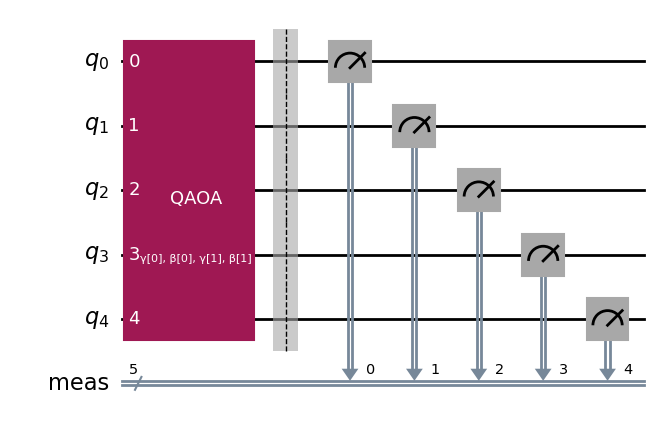

In [6]:
from qiskit.circuit.library import QAOAAnsatz

#QAOAAnsatz(cost_operator=None, reps=1, initial_state=None, mixer_operator=None, name='QAOA', flatten=None)
# initial_state = an optional initial state to use, if None is passed then a layer of hadamard gates is applied as an initial state to all qubits
# mixer_operator = An optional custom mixer to use instead of the global X-rotations (AKA applying a series of Pauli-X gates)
#   - rather than using a layer of Pauli X gates for the known hamiltonian, you can set a custom one here
# flatten - Set to True if you want to output a flat circuit instead of nesting it inside multiple layers of gate objects. By default, there are multiple nested objects for cleaner visualization, but this is not efficient

# QAOA uses quantum annealing (a method that gradually eases a quantum system from a simple state to a more complex state that represents the solution to a problem), it's a heuristic form AQC
# Here, reps = repetition, i.e., the p value or the number of steps
# of applying U(known_hamiltonian, angle1) U(unknown_hamiltonian, angle2)

# cost_operator = hamiltonian of interest (the one we want to get the ground state of)

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2) # create a QAOA circuit with 2 repetitions
circuit.measure_all() # adds measurement operations to all qubits in the circuit

circuit.draw('mpl') # draw the circuit

## Step 2. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distictively more likely than the rest.

QasmSimulator('qasm_simulator')


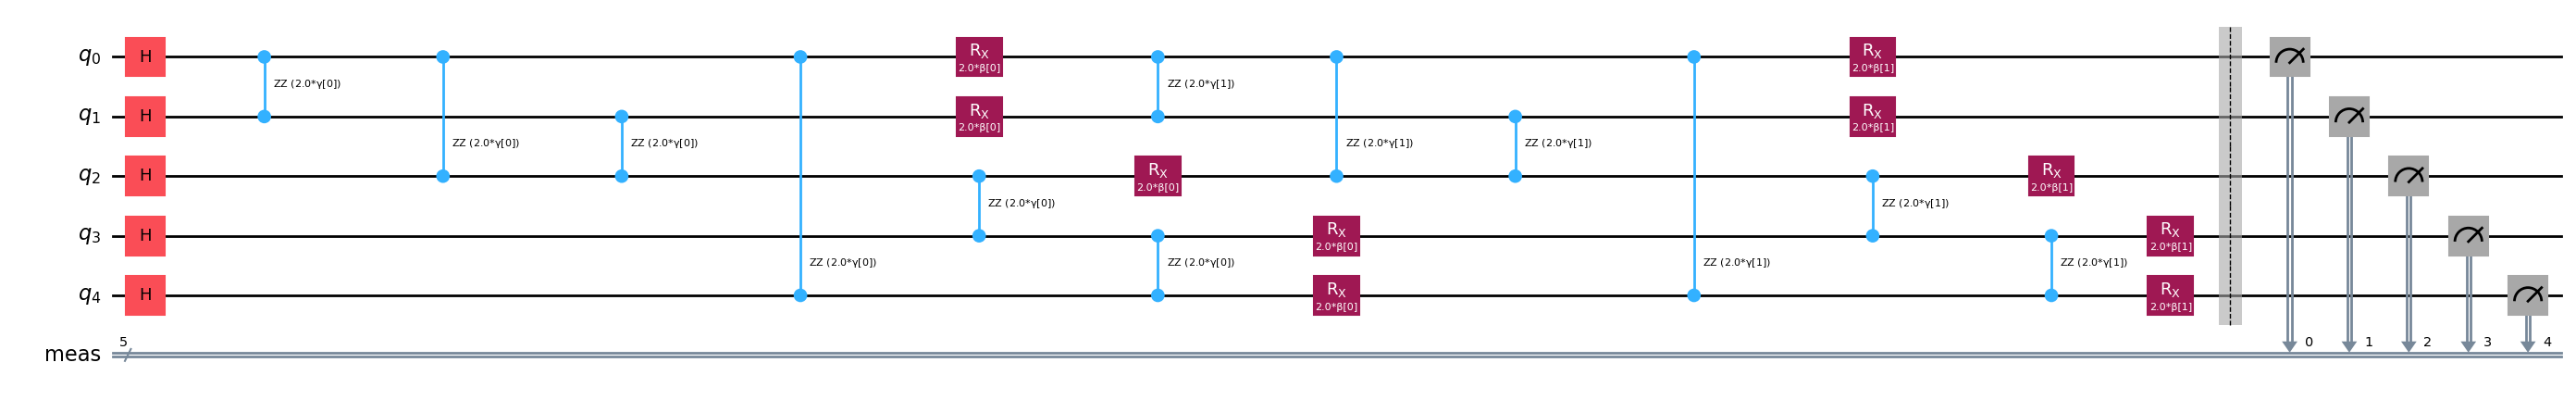

In [7]:
from qiskit_aer import Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = Aer.get_backend('qasm_simulator')
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [9]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [11]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.6793206793206794
       x: [ 2.938e+00  1.841e+00  3.451e+00  2.452e+00]
    nfev: 39
   maxcv: 0.0


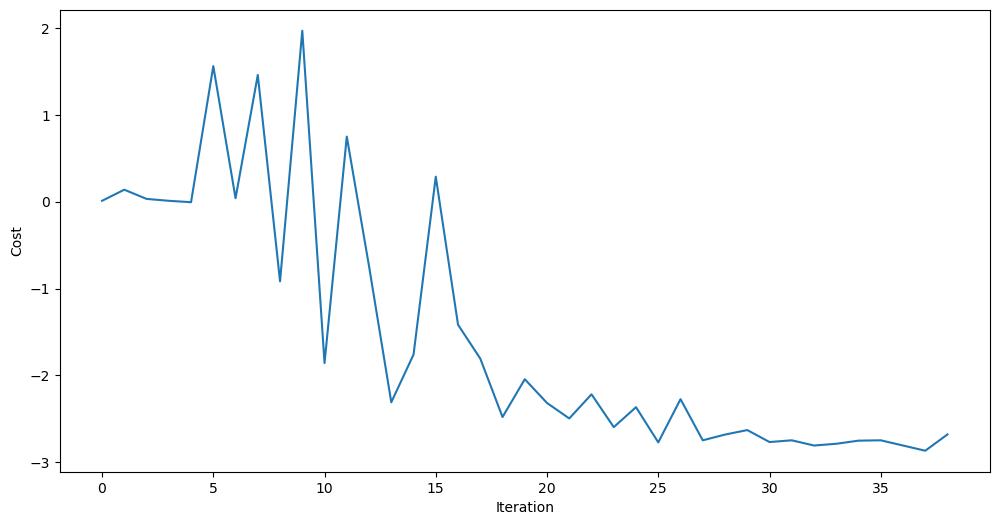

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

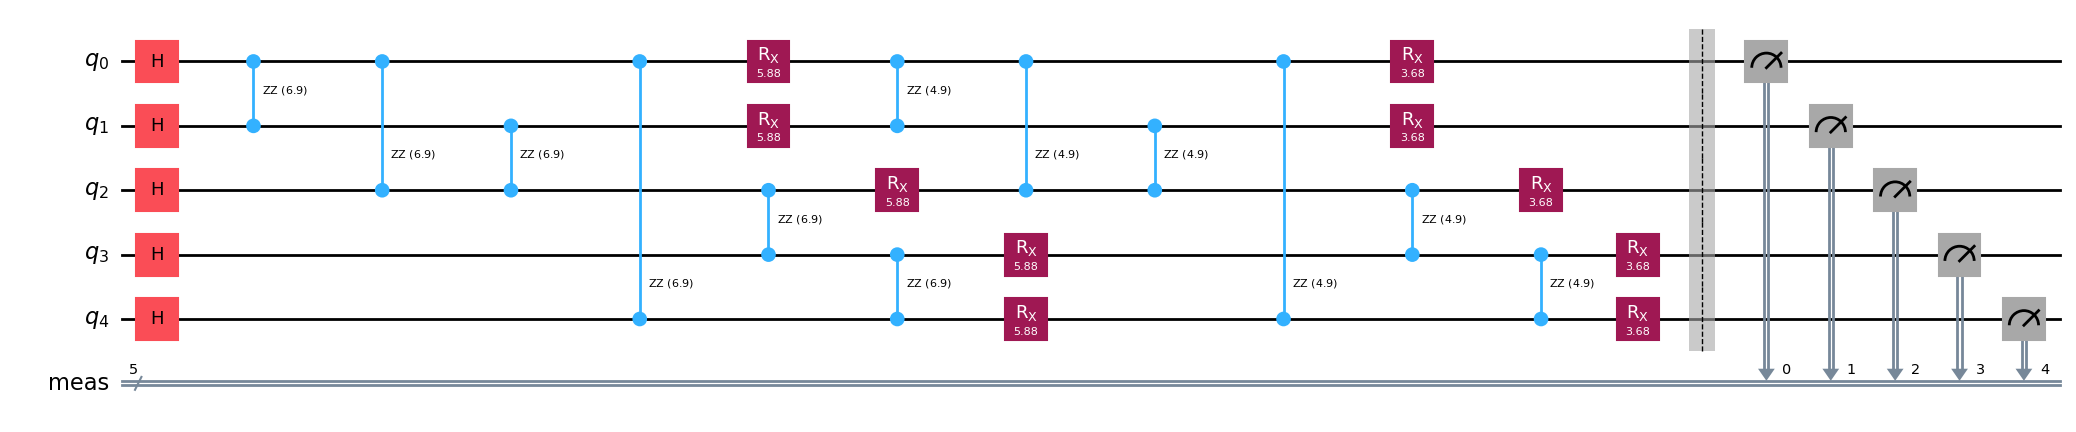

In [13]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{26: 0.0647, 14: 0.0197, 21: 0.0419, 18: 0.0441, 4: 0.0064, 20: 0.1417, 13: 0.0444, 5: 0.0646, 8: 0.0046, 22: 0.1389, 9: 0.1417, 29: 0.0062, 2: 0.0086, 11: 0.1362, 17: 0.016, 10: 0.0409, 23: 0.0039, 6: 0.0032, 16: 0.0034, 27: 0.0054, 19: 0.0157, 12: 0.0182, 28: 0.0041, 3: 0.0045, 24: 0.0001, 1: 0.0054, 30: 0.0052, 25: 0.0051, 15: 0.0045, 7: 0.0001, 0: 0.0003, 31: 0.0003}


In [15]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 0, 1]


TypeError: only length-1 arrays can be converted to Python scalars

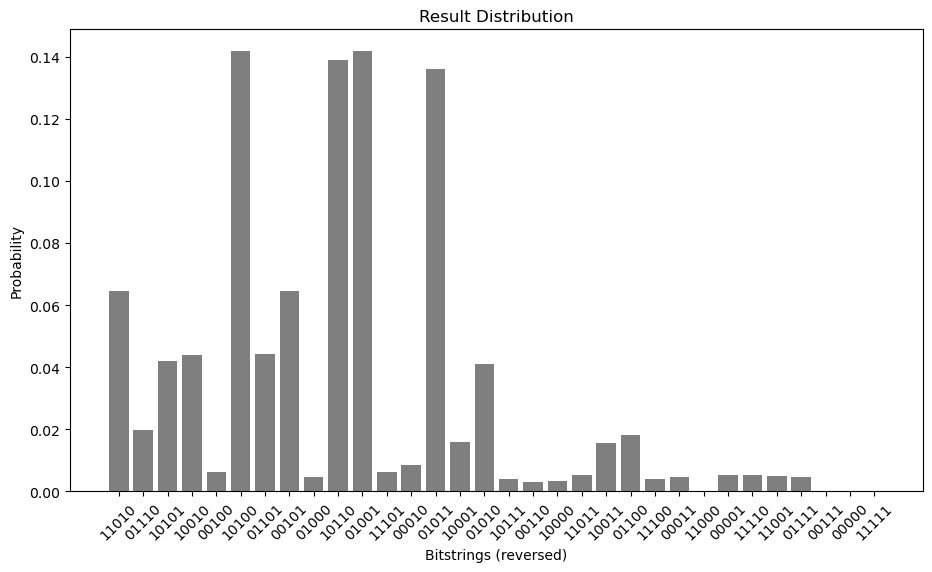

In [19]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

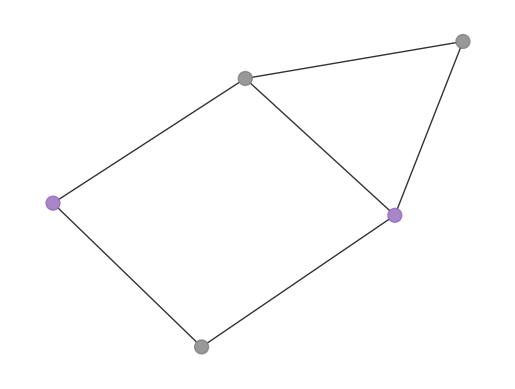

In [17]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [18]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5
